# Check Torch Version

In [19]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!nvcc --version

1.10.1 True
gcc (GCC) 8.5.0 20210514 (Red Hat 8.5.0-4)
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:13:23_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


# Install Detectron2

In [2]:
# import torch
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Import Detectron2

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode

from sklearn.decomposition import PCA
%matplotlib inline

# Train on a custom dataset

## Prepare the dataset

In [13]:
from detectron2.structures import BoxMode

DatasetCatalog.clear()

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "pig_coco.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    imgs_names = imgs_anns["images"]
    annos = imgs_anns["annotations"]
    
    dataset_dicts = []
    for idx, imgfile in enumerate(imgs_names):
        record = {}
        
        record["file_name"] = imgfile["file_name"]
        record["image_id"] = imgfile["id"]
        record["height"] = imgfile["height"]
        record["width"] = imgfile["width"]
      
        objs = []
        for anno in annos:
            if anno["image_id"] == imgfile["id"]:
                obj = {
                    "bbox": anno["bbox"],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": anno["segmentation"],
                    "category_id": 0,
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "test"]:
    DatasetCatalog.register("my_dataset_" + d, lambda d=d: get_balloon_dicts("/home/xiaodan/Documents/pig_segment/pig_life/" + d))
    MetadataCatalog.get("my_dataset_" + d).set(thing_classes=["pig"])
balloon_metadata = MetadataCatalog.get("my_dataset_train")

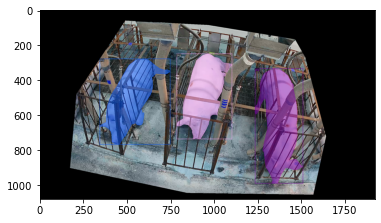

In [14]:
dataset_dicts = get_balloon_dicts("/home/xiaodan/Documents/pig_segment/pig_life/test")
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

## Train

In [15]:
model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

'/home/xiaodan/.conda/envs/pig/lib/python3.9/site-packages/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'

In [16]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [17]:
cfg.OUTPUT_DIR

'./output'

In [18]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/09 18:19:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/09 18:19:47 d2.data.build]: Removed 0 images with no usable annotations. 2592 images left.
[06/09 18:19:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    pig     | 11280        |
|            |              |
[06/09 18:19:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/09 18:19:48 d2.data.build]: Using training sampler TrainingSampler
[06/09 18:19:48 d2.data.common]: Serializing 2592 elements to byte tensors and concatenating them all ...
[06/09 18:19:48 d2.data.common]: Serialized dataset takes 5.65 MiB


model_final_f10217.pkl: 178MB [00:03, 48.1MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due t

[06/09 18:20:19 d2.engine.train_loop]: Starting training from iteration 0


/home/xiaodan/.conda/envs/pig/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/09 18:20:39 d2.utils.events]:  eta: 0:03:41  iter: 19  total_loss: 2.35  loss_cls: 0.6556  loss_box_reg: 0.9648  loss_mask: 0.6933  loss_rpn_cls: 0.01873  loss_rpn_loc: 0.02639  time: 0.7480  data_time: 0.5064  lr: 1.6068e-05  max_mem: 2672M
[06/09 18:20:55 d2.utils.events]:  eta: 0:03:25  iter: 39  total_loss: 2.287  loss_cls: 0.6001  loss_box_reg: 0.9459  loss_mask: 0.6819  loss_rpn_cls: 0.01229  loss_rpn_loc: 0.02249  time: 0.7787  data_time: 0.5558  lr: 3.2718e-05  max_mem: 2672M
[06/09 18:21:11 d2.utils.events]:  eta: 0:03:09  iter: 59  total_loss: 2.179  loss_cls: 0.5244  loss_box_reg: 0.958  loss_mask: 0.6558  loss_rpn_cls: 0.01377  loss_rpn_loc: 0.02353  time: 0.7844  data_time: 0.5637  lr: 4.9367e-05  max_mem: 2672M
[06/09 18:21:27 d2.utils.events]:  eta: 0:02:55  iter: 79  total_loss: 2.077  loss_cls: 0.469  loss_box_reg: 0.9573  loss_mask: 0.6233  loss_rpn_cls: 0.01068  loss_rpn_loc: 0.02188  time: 0.7940  data_time: 0.6000  lr: 6.6017e-05  max_mem: 2672M
[06/09 18:21:43

## Testing

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/09 18:26:50 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

True

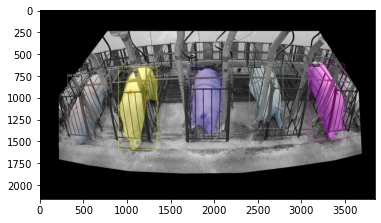

In [21]:
from detectron2.utils.visualizer import ColorMode


im = cv2.imread('./pig_life/test/1050s1132a1110s3003-5s5001-1(525).png')
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=balloon_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_img = out.get_image()[:, :, ::-1]
out_img = cv2.resize(out_img, dsize=(3840, 2160))
plt.imshow(out_img)
cv2.imwrite('./output_img/foo.png', out.get_image()[:, :, ::-1])

True

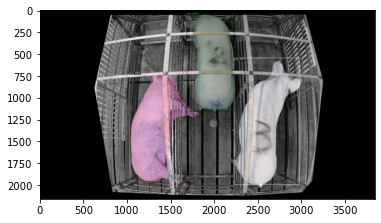

In [22]:
from detectron2.utils.visualizer import ColorMode


im = cv2.imread('./pig_life/test/1040s1132s3005-3s5001-1(30).png')
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=balloon_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_img = out.get_image()[:, :, ::-1]
out_img = cv2.resize(out_img, dsize=(3840, 2160))
plt.imshow(out_img)
cv2.imwrite('./output_img/foo2.png', out.get_image()[:, :, ::-1])


## Load model and inference on your image

In [ ]:
### load model ###
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)